In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
import kagglehub
import cv2 as cv




In [3]:
train_datagen=ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)
val_datagen=ImageDataGenerator( preprocessing_function=preprocess_input,validation_split=0.2)
test_datagen=ImageDataGenerator( preprocessing_function=preprocess_input)

In [15]:
batch_size=16
image_shape=(128,128)
train=train_datagen.flow_from_directory(
    r"C:\Users\VICTUS\Downloads\plants\PlantVillage\train",
   target_size=image_shape,
    batch_size=batch_size, 
    class_mode='categorical',
    subset='training'
)
val=val_datagen.flow_from_directory(
    r"C:\Users\VICTUS\Downloads\plants\PlantVillage\train",
     target_size=image_shape,
    batch_size=batch_size, 
    class_mode='categorical',
    subset='validation')
test=test_datagen.flow_from_directory(
    r"C:\Users\VICTUS\Downloads\plants\PlantVillage\val",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 34771 images belonging to 38 classes.
Found 8673 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [16]:
base=MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3)
)
base.trainable=False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
model=Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(38,activation='softmax')

])
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6, restore_best_weights=True),
   
]


history=model.fit(
    train,epochs=10,batch_size=16,validation_data=val,callbacks=callbacks
)

Epoch 1/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 910s 416ms/step - accuracy: 0.6853 - loss: 1.1503 - val_accuracy: 0.8623 - val_loss: 0.4506
Epoch 2/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 948s 436ms/step - accuracy: 0.8178 - loss: 0.5939 - val_accuracy: 0.8890 - val_loss: 0.3359
Epoch 3/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 979s 450ms/step - accuracy: 0.8452 - loss: 0.4970 - val_accuracy: 0.9037 - val_loss: 0.2911
Epoch 4/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 1076s 495ms/step - accuracy: 0.8574 - loss: 0.4541 - val_accuracy: 0.9091 - val_loss: 0.2731
Epoch 5/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 874s 390ms/step - accuracy: 0.8672 - loss: 0.4218 - val_accuracy: 0.9161 - val_loss: 0.2565
Epoch 6/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 2579s 1s/step - accuracy: 0.8727 - loss: 0.4010 - val_accuracy: 0.9208 - val_loss: 0.2435
Epoch 7/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 2156s 992ms/step - accuracy: 0.8744 - loss: 0.3896 - val_accuracy: 0.9140 - val_loss: 0.2523
Epoch 8/10
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 1489s 685ms/step - a

In [23]:
model.save('plants_disease_model.keras')

679/679 ━━━━━━━━━━━━━━━━━━━━ 127s 186ms/step - accuracy: 0.9240 - loss: 0.2285


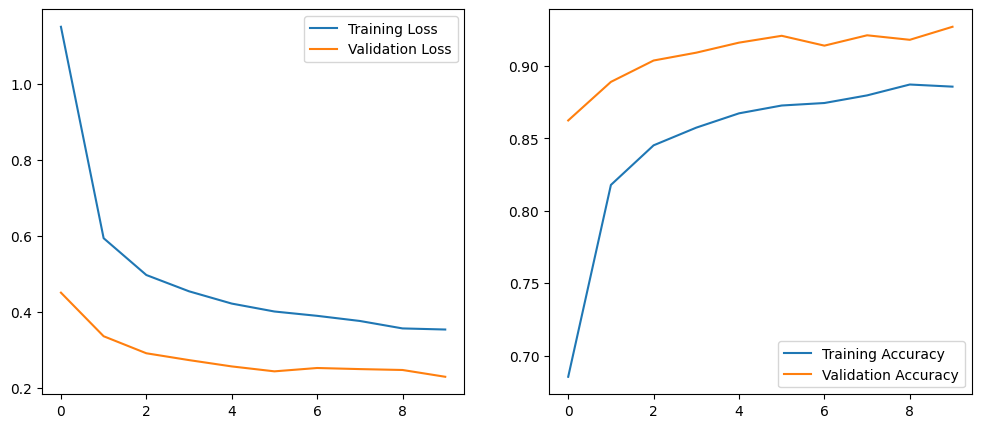

In [19]:
loss,accuracy=model.evaluate(test)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

679/679 ━━━━━━━━━━━━━━━━━━━━ 135s 199ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.85      0.90       126
                                 Apple___Black_rot       0.95      0.99      0.97       125
                          Apple___Cedar_apple_rust       0.93      0.98      0.96        55
                                   Apple___healthy       0.96      0.91      0.94       329
                               Blueberry___healthy       0.95      0.89      0.92       300
          Cherry_(including_sour)___Powdery_mildew       1.00      0.93      0.97       210
                 Cherry_(including_sour)___healthy       0.88      0.99      0.93       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.56      0.69       103
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       239
               Corn_(maize)___Nort

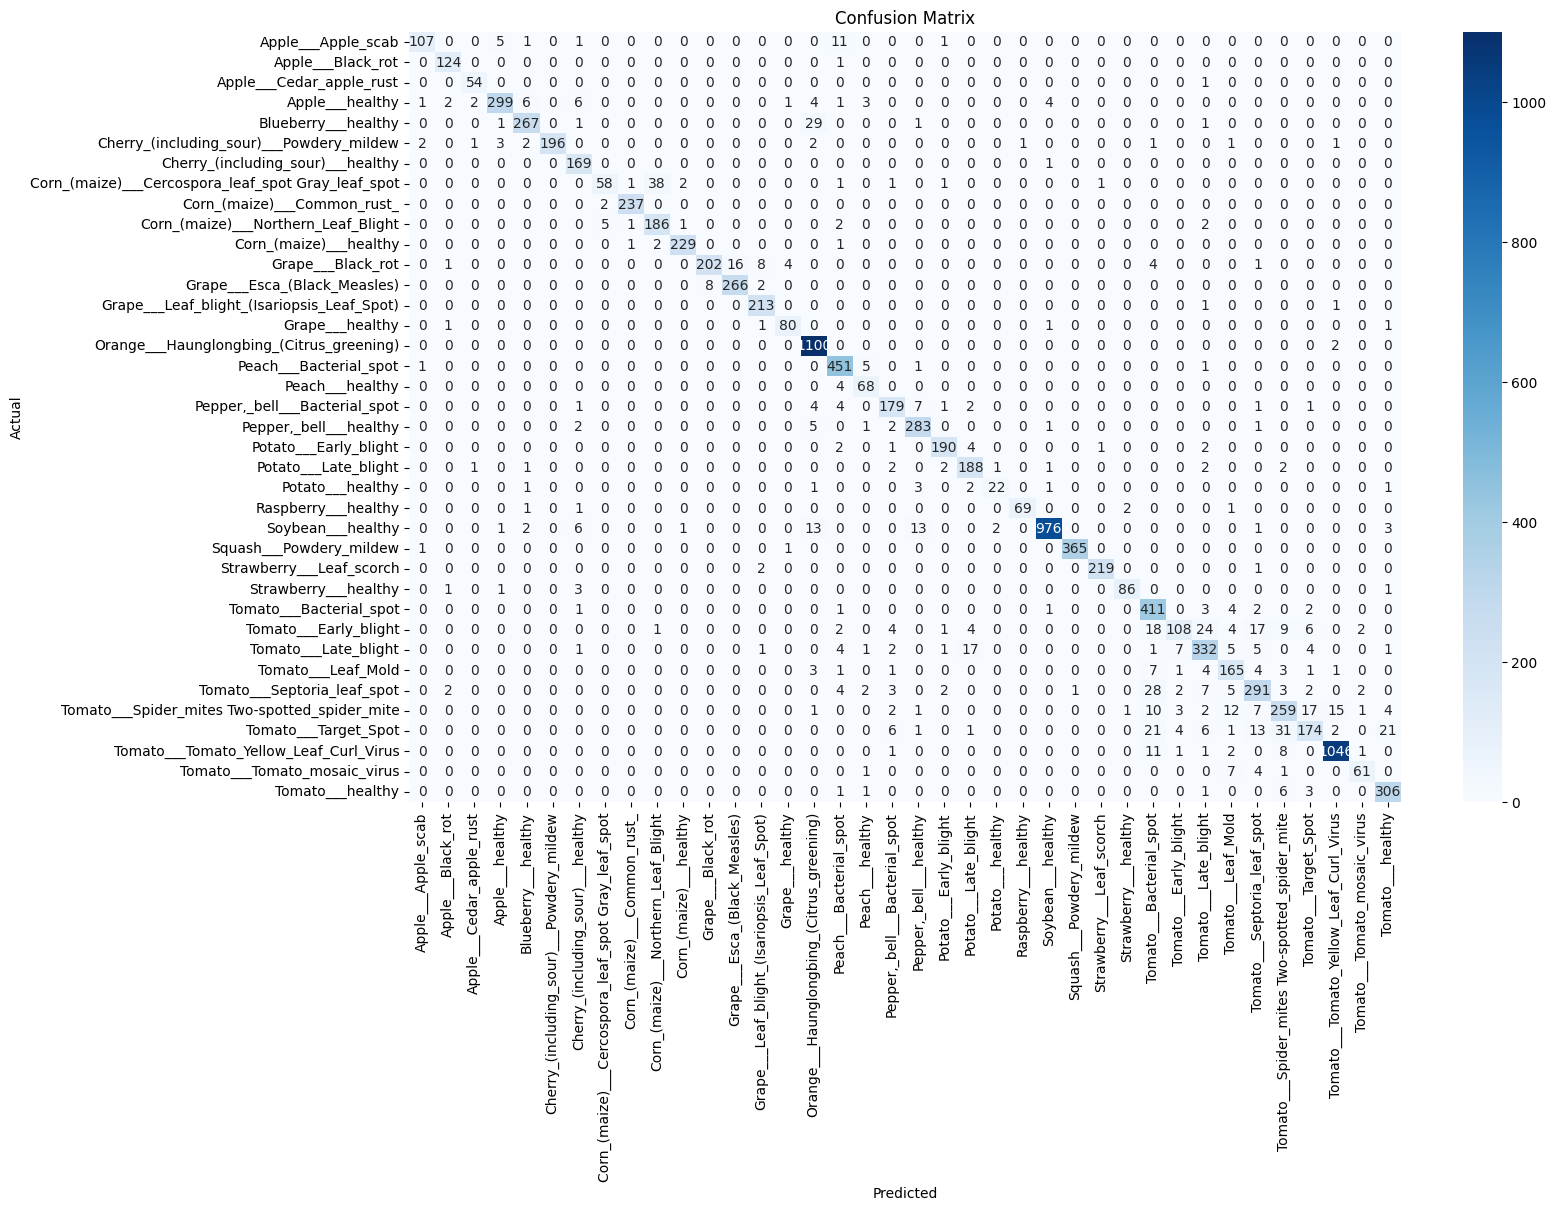

In [22]:

predictions=model.predict(test)
y_pred=np.argmax(predictions,axis=1)
print(classification_report(test.classes,y_pred,target_names=test.class_indices.keys()))
cm=confusion_matrix(test.classes,y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=test.class_indices.keys(),yticklabels=test.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [3]:
from keras.models import load_model

model=load_model(r'D:\python\Aiml\projects\plants\Plant_deseases_classification\plants_disease_model.keras')
img=cv.imread(r"C:\Users\VICTUS\Downloads\grape_black_rot.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img=cv.resize(img,(128,128))
img=img.astype('float32')/255.0
img=np.expand_dims(img,axis=0)
pred=model.predict(img,verbose=0)
deseases=['Apple scab','Apple Black rot',' Cedar apple rust','Apple healthy',
              'Blueberry healthy','Cherry (including sour) Powdery mildew','Cherry (including sour) healthy',
              'Corn (maize) Cercospora leaf spot Gray leaf spot','Corn (maize) Common rust ','Corn (maize) Northern Leaf Blight',
              'Corn (maize) healthy','Grape Black rot','Grape Esca (Black Measles)','Grape Leaf blight (Isariopsis Leaf Spot)',
              'Grape healthy','Orange Haunglongbing (Citrus greening)','Peach Bacterial spot','Peach healthy',
              'Pepper, bell Bacterial spot','Pepper, bell healthy','Potato Early blight','Potato Late blight',
              'Potato healthy','Raspberry healthy','Soybean healthy','Squash Powdery mildew',
              'Strawberry Leaf scorch','Strawberry healthy','Tomato Bacterial spot','Tomato Early blight',
              'Tomato Late blight','Tomato Leaf Mold','Tomato Septoria leaf spot','Tomato Spider mites Two-spotted spider mite',
              'Tomato Target Spot','Tomato Tomato Yellow Leaf Curl Virus','Tomato Tomato mosaic virus',
              'Tomato healthy']
print(f'Prediction: {deseases[np.argmax(pred)]}')

Prediction: Grape Black rot
